In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# definición de funciones de pérdida distintas y sus derivadas.
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(2/n) * (X.T @ (y_true - y_pred))

def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mae_gradient(X, y_true, y_pred):
    n = X.shape[0]
    return -(1/n) * (X.T @ np.sign(y_true - y_pred))

In [ ]:
def plot_loss(train_errors, val_errors):
    # gráfico de errores.
    plt.figure(figsize=(12, 4))
    plt.plot(train_errors, label='train_loss')
    plt.plot(val_errors, label='val_loss')
    plt.xlabel('Iteración')
    plt.ylabel('Loss')
    plt.title('Evolución de función de pérdida vs iteraciones')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_parameters(coef_history):
    # gráfico de coeficientes.
    coef_history = np.array(coef_history)
    plt.figure(figsize=(12, 4))
    for j in range(coef_history.shape[1]):
        plt.plot(coef_history[:, j], label=f'beta_{j}')
    plt.xlabel('Iteración')
    plt.ylabel('Valor del coeficiente')
    plt.title('Evolución de los coeficientes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient):
    """
    Gradient Descent para regresión lineal con tracking de errores y coeficientes.
    
    Parámetros:
    -----------
    X_train : ndarray de shape (n, m)
        Datos de entrenamiento.
    y_train : ndarray de shape (n, 1)
        Etiquetas de entrenamiento.
    X_val : ndarray de shape (p, m)
        Datos de validación.
    y_val : ndarray de shape (p, 1)
        Etiquetas de validación.
    lr : float, opcional (default=0.01)
        Tasa de aprendizaje.
    epochs : int, opcional (default=100)
        Número de iteraciones.
    grad_fn : (default = mse_gradient)
        Función de pérdida.

    Devuelve:
    --------
    W : ndarray de shape (m+1, 1)
        Pesos finales aprendidos.
    """

    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    # se guardan dimensiones
    n, m = X_train.shape
    o = X_val.shape[0]

    # se agrega columna de unos a las matrices X para considerar los términos independientes (no hacerlo implica forzar término independiente a nulo)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # se inicializan pesos aleatorios (m+1)x1
    W = np.random.randn(m+1, 1)

    # listas para guardar evolución de errores y coeficientes a lo largo de las iteraciones
    # los coeficientes ya tienen un valor inicial (W).
    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        # como ya hay una inicialización de los coeficientes, se calcula con ellos el ajuste al conjunto de entrenamiento y validación.
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W

        error_train = y_train - y_pred_train
        error_val = y_val - y_pred_val

        train_mse = np.mean(error_train ** 2)
        val_mse = np.mean(error_val ** 2)

        train_errors.append(train_mse)
        val_errors.append(val_mse)

        # calculo gradiente , uso la función que se pasa como parámetro.
        gradient = grad_fn(X_train, y_train, y_pred_train)
        W -= lr * gradient

        # se guarda coeficientes para plot.
        coef_history.append(W.flatten())

    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    return W


In [16]:
def stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, grad_fn=mse_gradient, batch_size=1):
    """
    Stochastic Gradient Descent (SGD) para regresión lineal con tracking de errores y coeficientes.
    
    Parámetros:
    -----------
    X_train, y_train, X_val, y_val : datos de entrenamiento y validación
    lr : tasa de aprendizaje
    epochs : número de pasadas completas sobre el dataset
    grad_fn : función de gradiente (default = mse_gradient)
    batch_size : tamaño del lote (1 = SGD puro, >1 = Mini-batch SGD)

    Devuelve:
    ---------
    W : ndarray de shape (m+1, 1)
        Pesos finales aprendidos.
    """

    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        # se mezclan índices para que cada época tenga distinto orden de muestras
        indices = np.random.permutation(n)

        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        # errores globales después de cada época
        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())

    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    return W

In [22]:
def mini_batch_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, batch_size=32, grad_fn=mse_gradient):
    """
    Mini-Batch Gradient Descent (MBGD) para regresión lineal con tracking de errores y coeficientes.
    Notar que esta función se puede usar directamente para los tres casos: si batch_size = 1, es el caso de SGD.
    Si batch_size = len(X), es el caso de GD.
    
    Parámetros:
    -----------
    X_train, y_train, X_val, y_val : datos de entrenamiento y validación
    lr : tasa de aprendizaje
    epochs : número de pasadas completas sobre el dataset
    batch_size : tamaño de cada mini-lote
    grad_fn : función de gradiente (default = mse_gradient)

    Devuelve:
    ---------
    W : ndarray de shape (m+1, 1)
        Pesos finales aprendidos.
    """

    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    W = np.random.randn(m+1, 1)

    train_errors, val_errors, coef_history = [], [], [W.flatten()]

    for _ in range(epochs):
        indices = np.random.permutation(n)

        # usamos batches para el cálculo.
        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            y_pred_batch = X_batch @ W
            gradient = grad_fn(X_batch, y_batch, y_pred_batch)
            W -= lr * gradient

        y_pred_train = X_train @ W
        y_pred_val = X_val @ W
        train_errors.append(np.mean((y_train - y_pred_train) ** 2))
        val_errors.append(np.mean((y_val - y_pred_val) ** 2))

        coef_history.append(W.flatten())

    plot_loss(train_errors, val_errors)
    plot_parameters(coef_history)

    return W


In [4]:
income = pd.read_csv(f'data/happyscore_income.csv')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(income['GDP'], income['happyScore'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((77,), (11,), (23,))

In [7]:
X_train.values.reshape(11,7)

array([[0.92049, 0.63216, 0.89012, 0.99355, 0.73479, 0.25812, 0.271  ],
       [1.08254, 1.20813, 1.12254, 1.13764, 1.39651, 1.32548, 1.01216],
       [0.7419 , 1.03192, 1.33723, 0.33024, 1.25114, 0.76454, 1.39451],
       [0.46038, 0.75985, 1.06098, 0.22208, 0.9669 , 0.19073, 1.06024],
       [1.05351, 0.82827, 0.80148, 0.89537, 1.30782, 1.0088 , 1.11312],
       [1.17898, 1.33171, 0.75778, 1.33596, 0.0712 , 0.98124, 0.59543],
       [0.2852 , 0.88113, 0.39753, 0.64499, 1.18498, 0.36471, 1.02389],
       [0.47428, 0.0694 , 0.54558, 0.79907, 0.36498, 1.27074, 1.04345],
       [1.30232, 1.32792, 1.06166, 0.83524, 0.37545, 0.39047, 1.459  ],
       [0.4225 , 0.95578, 1.56391, 0.21102, 1.23011, 0.82819, 1.14723],
       [0.92053, 1.12486, 1.32629, 0.59325, 0.91861, 0.59532, 1.12555]])

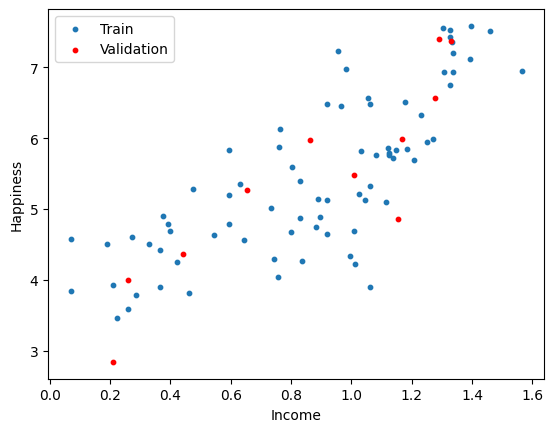

In [8]:
fig, ax = plt.subplots()
ax.scatter(X_train.values, y_train, s=10)
ax.scatter(X_val.values, y_val, s=10, color='red')

ax.set_xlabel('Income')
ax.set_ylabel('Happiness')
ax.legend(['Train', 'Validation'])
plt.show()

In [9]:
X_train= X_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
X_val= X_val.values.reshape(-1, 1)
y_val= y_val.values.reshape(-1, 1)
X_test= X_test.values.reshape(-1, 1)
y_test= y_test.values.reshape(-1, 1)

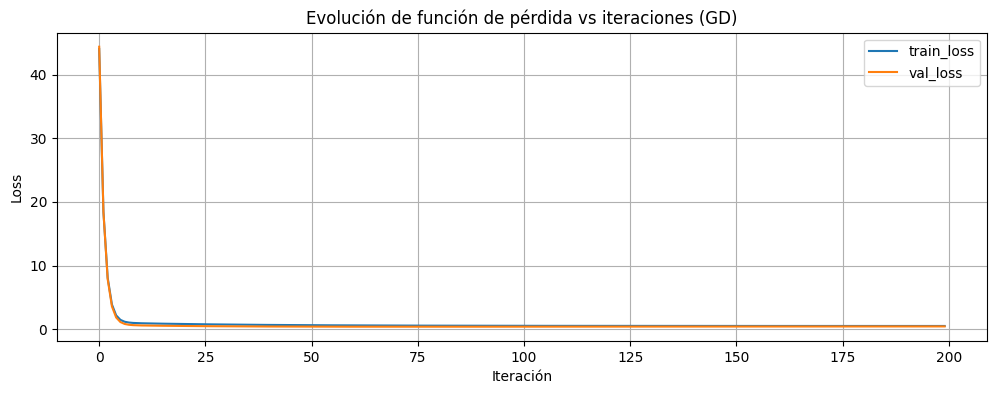

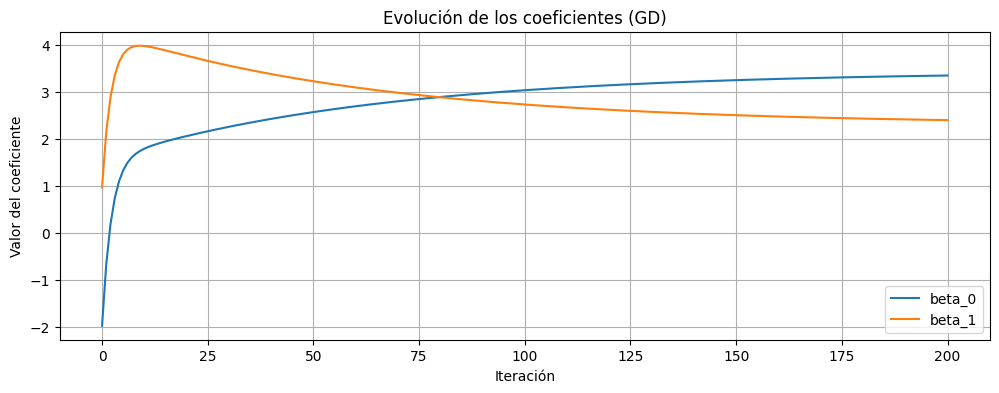

array([[3.35552101],
       [2.40529501]])

In [15]:
gradient_descent(X_train, y_train, X_val, y_val, lr=0.1, epochs=200)

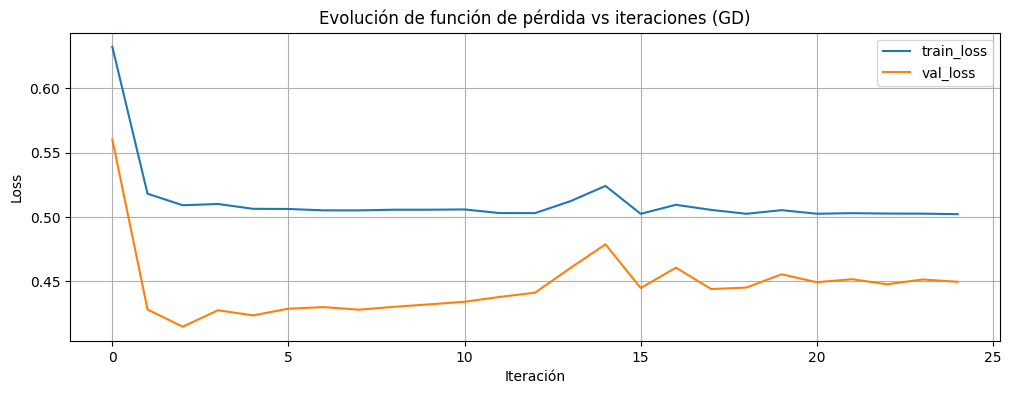

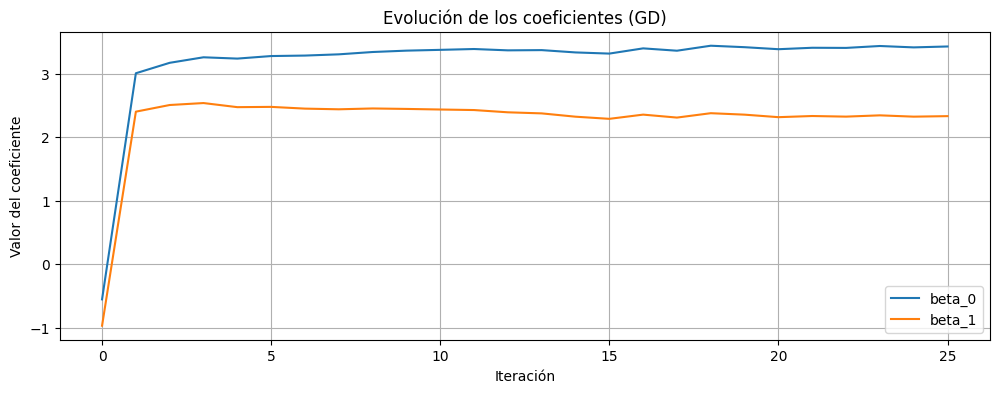

array([[3.42709926],
       [2.3314094 ]])

In [21]:
stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=25)

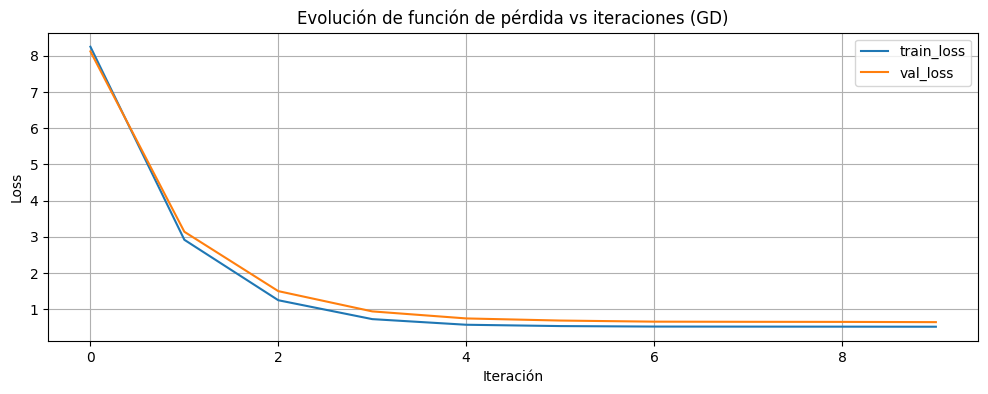

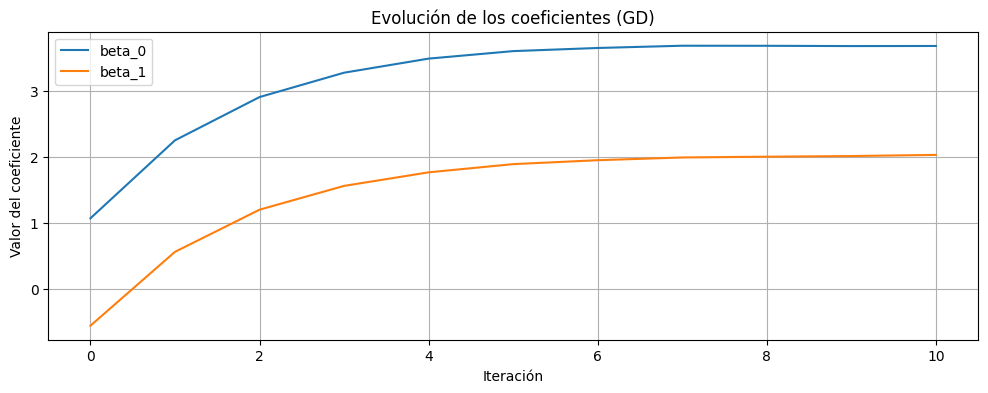

array([[3.68227399],
       [2.03351777]])

In [32]:
mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, batch_size=5, epochs=10, grad_fn=mse_gradient)

# descent gradient para el dataset de possum

In [ ]:
df = pd.read_csv('data/possum.csv')
df = df.loc[:,'sex':]
df = df[df.isna().sum(axis=1) == 0]
df1 = pd.get_dummies(data=df, columns = ['sex'], drop_first=True)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop('totlngth', axis=1),
                                             df1['totlngth'].values.reshape(-1,1),
                                             test_size=0.2,
                                             random_state=12,
                                             )

X_train = np.asarray(X_train, dtype=float)
y_train = np.asarray(y_train, dtype=float).reshape(-1, 1)
X_test = np.asarray(X_test, dtype=float)
y_test = np.asarray(y_test, dtype=float).reshape(-1, 1)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 10), (21, 10), (80, 1), (21, 1))

c:\Users\joels\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\joels\AppData\Local\Temp\ipykernel_3696\294682847.py:54: RuntimeWarning: overflow encountered in square
  train_mse = np.mean(error_train ** 2)
C:\Users\joels\AppData\Local\Temp\ipykernel_3696\294682847.py:55: RuntimeWarning: overflow encountered in square
  val_mse = np.mean(error_val ** 2)
C:\Users\joels\AppData\Local\Temp\ipykernel_3696\1373704695.py:7: RuntimeWarning: overflow encountered in matmul
  return -(2/n) * (X.T @ (y_true - y_pred))
C:\Users\joels\AppData\Local\Temp\ipykernel_3696\1373704695.py:7: RuntimeWarning: invalid value encountered in matmul
  return -(2/n) * (X.T @ (y_true - y_pred))
C:\Users\joels\AppData\Local\Temp\ipykernel_3696\294682847.py:62: RuntimeWarning: invalid value encountered in subtract
  W -= lr * gradient


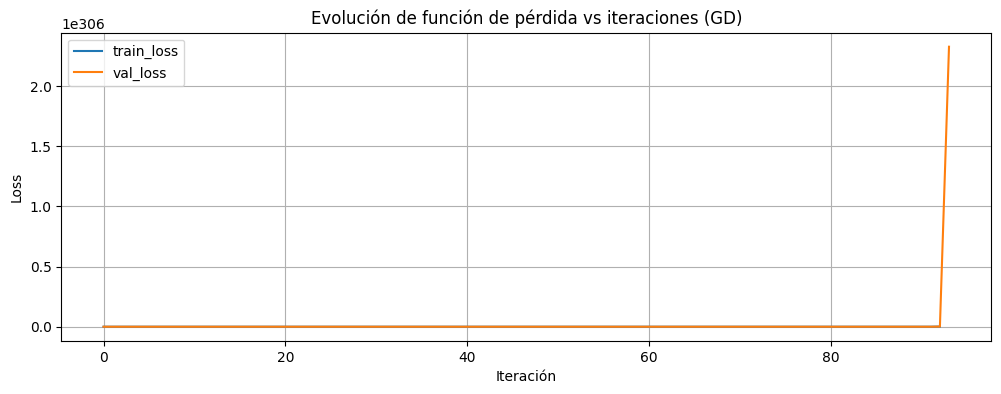

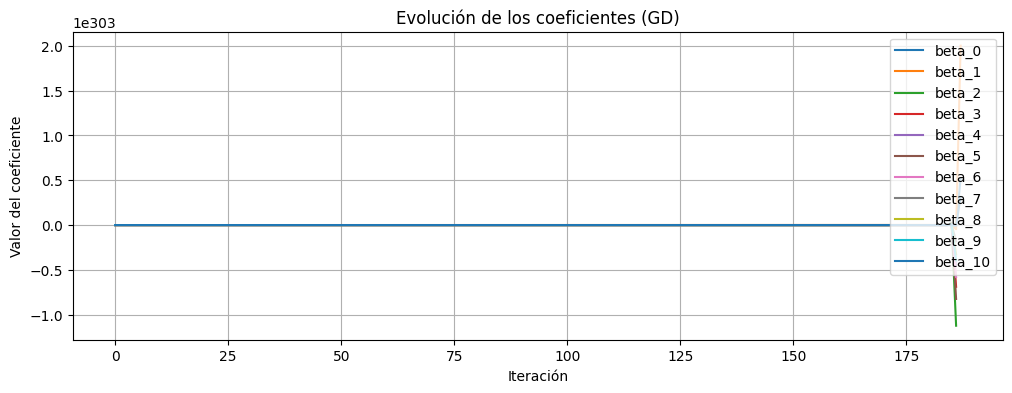

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [45]:
gradient_descent(X_train, y_train, X_test, y_test, epochs=200, lr=0.001)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

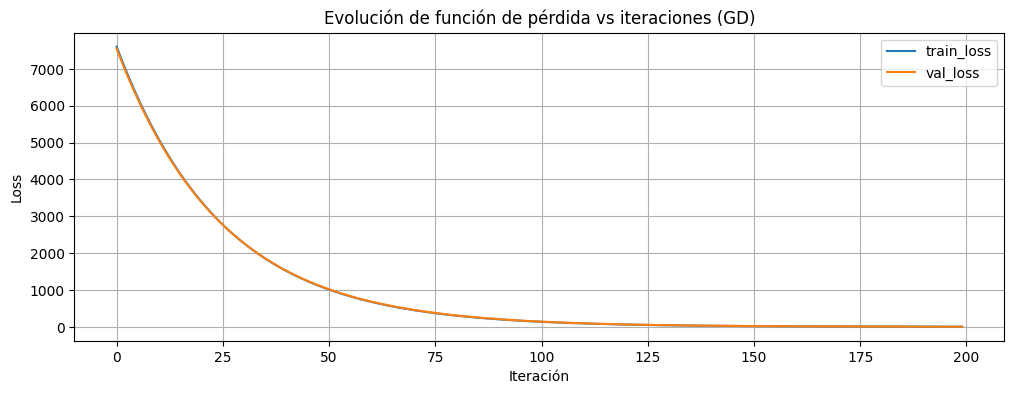

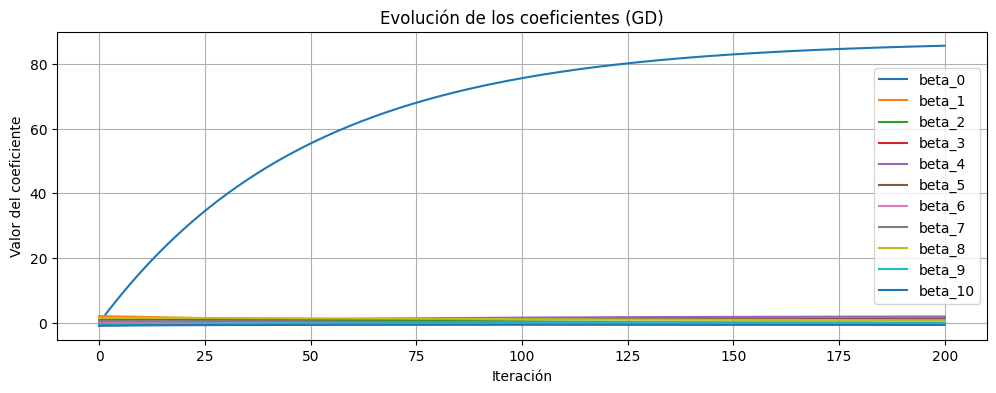

array([[ 8.55584841e+01],
       [ 1.35452567e-02],
       [ 1.33496621e+00],
       [-1.00285039e-01],
       [ 1.98873531e+00],
       [ 1.33970305e+00],
       [-5.69988458e-02],
       [ 1.08789418e-01],
       [ 7.82965849e-01],
       [-1.06361323e-01],
       [-6.26213980e-01]])

In [47]:
gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=200, lr=0.01)

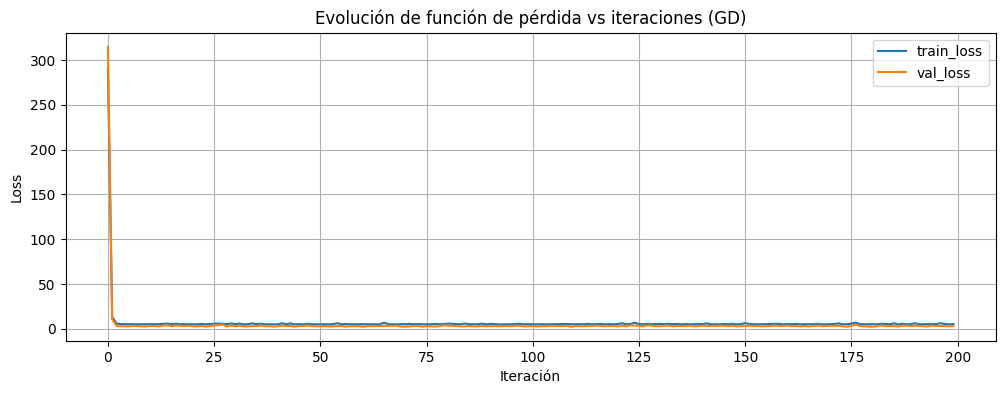

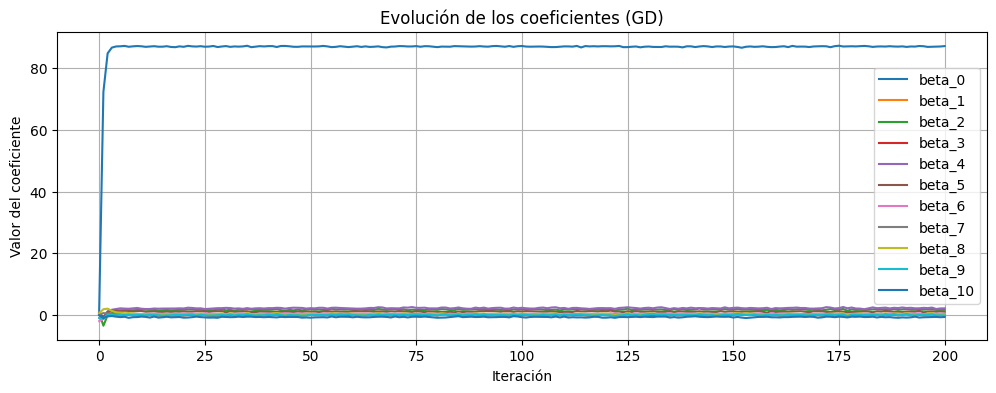

array([[ 8.72004921e+01],
       [-2.34342680e-01],
       [ 1.63030434e+00],
       [-7.08881235e-02],
       [ 2.11845209e+00],
       [ 1.03149767e+00],
       [ 3.15912668e-01],
       [ 1.60725613e-02],
       [ 1.53852185e-01],
       [-2.19378530e-01],
       [-6.94063251e-01]])

In [48]:
stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=200, lr=0.01)

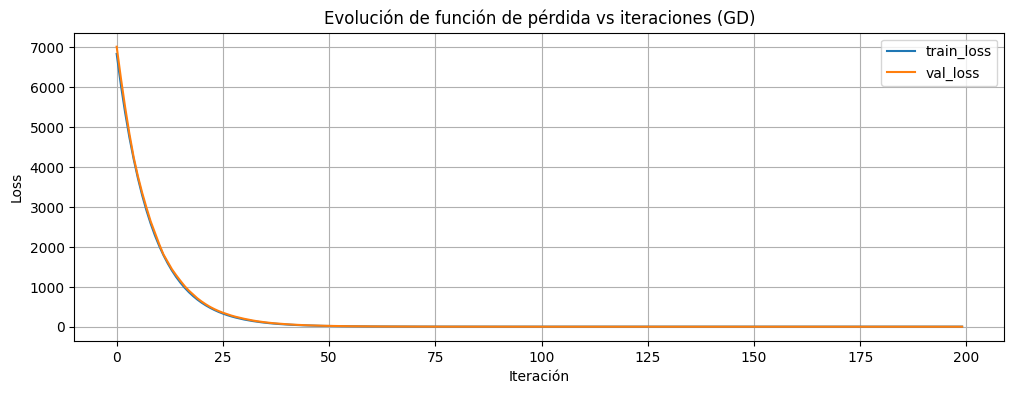

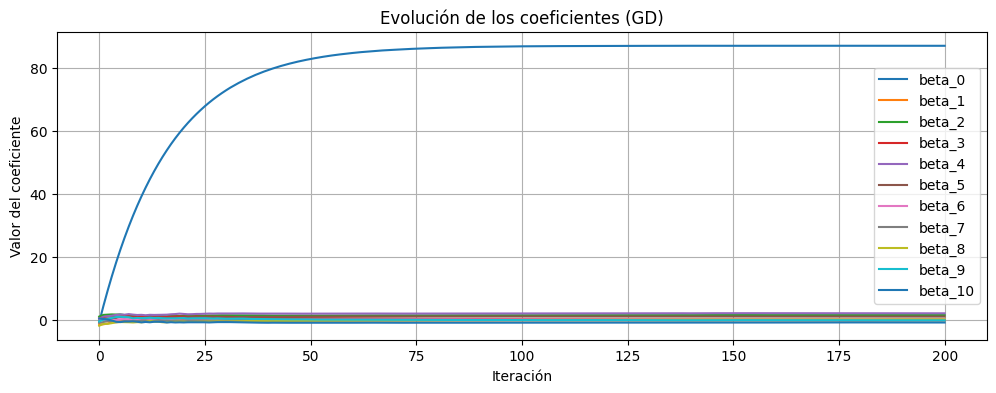

array([[ 8.70740811e+01],
       [-8.95994309e-02],
       [ 1.61324724e+00],
       [ 1.41283304e-01],
       [ 2.18432600e+00],
       [ 1.13848666e+00],
       [ 2.81349662e-01],
       [ 7.06337493e-02],
       [ 2.59052742e-01],
       [-5.47934465e-02],
       [-7.37479309e-01]])

In [49]:
mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, epochs=200, lr=0.01)